<a href="https://colab.research.google.com/github/mitesh98/Amazon-Fine-Food-Review/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews Analysis
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454

Number of users: 256,059

Number of products: 74,258

Timespan: Oct 1999 - Oct 2012

Number of Attributes/Columns in data: 10

Attribute Information:

Id

ProductId - unique identifier for the product

UserId - unqiue identifier for the user

ProfileName

HelpfulnessNumerator - number of users who found the review helpful

HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not

Score - rating between 1 and 5

Time - timestamp for the review

Summary - brief summary of the review
Text - text of the review

Objective: Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import nltk

from sklearn import metrics
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

import tqdm

In [0]:
import sqlite3

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "/content/drive/My Drive/database.sqlite" "database.sqlite"

# Readind Data

In [0]:
con=sqlite3.connect("database.sqlite")

In [0]:
filtered_data=pd.read_sql_query("SELECT * FROM `Reviews` WHERE `Score` !=3",con)
filtered_data.shape
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

In [0]:
actual_score=filtered_data['Score']
posnegative=actual_score.map(partition)
filtered_data['Score']=posnegative
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 2. Exploratory Data Analysis
# 2.1 Data Cleaning: Deduplication
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True)
sorted_data.shape

(525814, 10)

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)
final.shape

(364173, 10)

**Observation**:- bold text It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions



In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

In [0]:
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

# 3. Preprocessing
In the Preprocessing phase we do the following in the order below:-

1.Begin by removing the linksand html tags

2.Expand English language contractions and Remove any punctuations or limited set of special characters like , or . or # etc.

3.Check if the word is made up of english letters and is not alpha-numeric

4.Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

5.Convert the word to lowercase

6.Remove Stopwords

7.Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

In [0]:
#print(link)
for i in range(0,1000):
  links=re.findall(r'http\S+',final['Text'].values[i])
  for link in links:
    print(link)

http://www.amazon.com/gp/product/B0002DGRSY">Pro-Treat
http://www.amazon.com/gp/product/B0019O5Z0Q">Charlee
http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br
http://www.amazon.com/gp/product/B0088EDMMS">Hocus
http://www.amazon.com/gp/product/B001AGXEAG">Beetlejuice
http://www.amazon.com/gp/product/B001AGXEAG">here</a>.
http://www.amazon.com/gp/product/B001AGXEA6">here</a>.
http://www.amazon.com/gp/product/0790700506">Gremlins</a><br
http://www.amazon.com/gp/product/6301871952">Gremlins
http://www.amazon.com/gp/product/6303347657">Mask</a><br
http://www.amazon.com/gp/product/6304826141">Rocketman</a><br
http://www.amazon.com/gp/product/B001B504LI">The
http://www.amazon.com/gp/product/B001AGXEA6">Beetlejuice
http://www.amazon.com/gp/product/B00004RAMX">Victor
http://www.amazon.com/gp/product/B00004RAMY">Victor
http://www.amazon.com/gp/product/B00004RAMY">Victor
http://www.amazon.com/gp/product/B001VJ3FP6">SentryHOME
http://www.amazon.com/gp/product/B0051GCTAW">Fiprogua

In [0]:
for i in range(0,364171):
  final['Text'].values[i] = re.sub(r"http\S+", "", final['Text'].values[i])

In [0]:
#Remove HTML tags
from bs4 import BeautifulSoup
for i in range(1,364171):
  soup = BeautifulSoup(final['Text'].values[i],'lxml')
  text = soup.get_text()
  final['Text'].values[i]=text

In [0]:
#Expanding English language contractions
def decontracted(phrase):
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase


In [0]:
for i in range(0,364171):
  #print(final['Text'].values[i])
  final['Text'].values[i]=decontracted(final['Text'].values[i])
  #print(final['Text'].values[i])

In [0]:
#remove words with numbers python
for i in range(1,364171):
  #print(final['Text'].values[i])
  final['Text'].values[i] = re.sub("\S*\d\S*", "", final['Text'].values[i]).strip()
  #print(final['Text'].values[i])

In [0]:
#remove spacial character:
for i in range(1,364171):
  final['Text'].values[i]= re.sub('[^A-Za-z0-9]+', ' ', final['Text'].values[i])


In [0]:
#Remove punctution
for i in range(1,364171):
  final['Text'].values[i]= re.sub(r'[!|#|$\%|&|*|?|,|.|\'|/|"|)|(]',r'', final['Text'].values[i])

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
#tqdm
#Instantly make your loops show a smart progress meter
# just wrap any iterable with tqdm(iterable), and you’re done!
from tqdm import tqdm
preprocessed_reviews = []
for i in tqdm(range(0,364171)):
  sentence=""
  #print(final['Text'].values[i])
  for word in final['Text'].values[i].split():
    #print(word)
    word =word.lower()
    if word not in stopwords:
      sentence+=" "+word
  #print(sentence)
  preprocessed_reviews.append(sentence.strip())

100%|██████████| 364171/364171 [00:15<00:00, 23969.65it/s]


In [0]:
preprocessed_reviews[364170]

'purchased send son away college delivered right dorm room fast shipping loved much called thank sadly hardly ever calls anymore want kids call home good snack get midterms send'

In [0]:
final['Cleaned_text']=preprocessed_reviews
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud. recite...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version",I grew up reading these Sendak books and watch...,grew reading sendak books watching really rosi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud it h...,great little book read aloud nice rhythm well ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...


In [0]:
#Randomly sample Data 100k points
random_sample_data = final.sample(n=100000) 

In [0]:
#Randomly sample Data 20k points
random_sample_data_rbf = final.sample(n=20000) 

In [0]:
final_sorted_time=random_sample_data.sort_values('Time',ascending=True,axis=0)

In [0]:
final_sorted_time_rbf=random_sample_data_rbf.sort_values('Time',ascending=True,axis=0)

**Time dependent Splitting**

In [0]:
y_Train=final_sorted_time['Score'][0:70000]
y_train=final_sorted_time['Score'][0:49000]
y_cv=final_sorted_time['Score'][49000:70000]
y_test=final_sorted_time['Score'][70000:100000]

In [0]:
y_Train_rbf=final_sorted_time_rbf['Score'][0:14000]
y_train_rbf=final_sorted_time_rbf['Score'][0:9800]
y_cv_rbf=final_sorted_time_rbf['Score'][9800:14000]
y_test_rbf=final_sorted_time_rbf['Score'][14000:20000]

In [0]:
y_train.value_counts()

1    42232
0     6768
Name: Score, dtype: int64

In [0]:
y_train_rbf.value_counts()

1    8446
0    1354
Name: Score, dtype: int64

In [0]:
y_Train.value_counts()

1    59710
0    10290
Name: Score, dtype: int64

In [0]:
y_Train_rbf.value_counts()

1    11901
0     2099
Name: Score, dtype: int64

In [0]:
Train_data=final_sorted_time['Cleaned_text'][0:70000]
train_data=final_sorted_time['Cleaned_text'][0:49000]
cv_data=final_sorted_time['Cleaned_text'][49000:70000]
test_data=final_sorted_time['Cleaned_text'][70000:100000]

In [0]:
Train_data_rbf=final_sorted_time_rbf['Cleaned_text'][0:14000]
train_data_rbf=final_sorted_time_rbf['Cleaned_text'][0:9800]
cv_data_rbf=final_sorted_time_rbf['Cleaned_text'][9800:14000]
test_data_rbf=final_sorted_time_rbf['Cleaned_text'][14000:20000]

# 4. Featurization

# 4.1Bag of Words

In [0]:
count_vector=CountVectorizer()
train_bows=count_vector.fit_transform(train_data)
cv_bows=count_vector.transform(cv_data)

In [0]:
count_vector_rbf=CountVectorizer(min_df = 10, max_features = 500)
train_bows_rbf=count_vector_rbf.fit_transform(train_data_rbf)
cv_bows_rbf=count_vector_rbf.transform(cv_data_rbf)

# 4.2 TFIDF

In [0]:
tfidf_vector=TfidfVectorizer()
train_tfidf=tfidf_vector.fit_transform(train_data)
cv_tfidf=tfidf_vector.transform(cv_data)

In [0]:
tfidf_vector_rbf=TfidfVectorizer()
train_tfidf_rbf=tfidf_vector_rbf.fit_transform(train_data_rbf)
cv_tfidf_rbf=tfidf_vector_rbf.transform(cv_data_rbf)

# 4.3 Word2Vec

In [0]:
import gensim
from gensim.models import Word2Vec

In [0]:
#Train own W2V with train data
i=0
list_of_sentence=[]
for sent in train_data.values:
  list_of_sentence.append(sent.split())

In [0]:
w2v_model=gensim.models.Word2Vec(list_of_sentence,min_count=5,size=50,workers=4)

In [0]:
w2v_words = list(w2v_model.wv.vocab)

In [0]:
# Average W2V with training Data
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
#print(sent_vectors)
print(len(sent_vectors[0]))

49000
50


In [0]:
#Train own W2V with cv data
i=0
list_of_sentence_cv=[]
for sent in cv_data.values:
  list_of_sentence_cv.append(sent.split())

In [0]:
w2v_model_cv=gensim.models.Word2Vec(list_of_sentence_cv,min_count=5,size=50,workers=4)

In [0]:
w2v_words_cv = list(w2v_model_cv.wv.vocab)

In [0]:
# Average W2V with cv Data
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_cv:
            vec = w2v_model_cv.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
#print(sent_vectors)
print(len(sent_vectors_cv[0]))

21000
50


In [0]:
#Train own W2V with Test data
i=0
list_of_sentence_test=[]
for sent in test_data.values:
  list_of_sentence_test.append(sent.split())

In [0]:
w2v_model_test=gensim.models.Word2Vec(list_of_sentence_test,min_count=5,size=50,workers=4)

In [0]:
w2v_words_test = list(w2v_model_test.wv.vocab)

In [0]:
# Average W2V with test Data
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test:
            vec = w2v_model_test.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
#print(sent_vectors)
print(len(sent_vectors_test[0]))

30000
50


**Word2Vec For RBF**

In [0]:
import gensim
from gensim.models import Word2Vec

In [0]:
#Train own W2V with train data
i=0
list_of_sentence_rbf=[]
for sent in train_data_rbf.values:
  list_of_sentence_rbf.append(sent.split())

In [0]:
w2v_model_rbf=gensim.models.Word2Vec(list_of_sentence_rbf,min_count=5,size=50,workers=4)

In [0]:
w2v_words_rbf = list(w2v_model_rbf.wv.vocab)

In [0]:
# Average W2V with training Data
sent_vectors_rbf = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence_rbf: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_rbf:
            vec = w2v_model_rbf.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_rbf.append(sent_vec)
print(len(sent_vectors_rbf))
#print(sent_vectors)
print(len(sent_vectors_rbf[0]))

9800
50


In [0]:
#Train own W2V with cv data
i=0
list_of_sentence_rbf_cv=[]
for sent in cv_data_rbf.values:
  list_of_sentence_rbf_cv.append(sent.split())

In [0]:
w2v_model_rbf_cv=gensim.models.Word2Vec(list_of_sentence_rbf_cv,min_count=5,size=50,workers=4)

In [0]:
w2v_words_rbf_cv = list(w2v_model_rbf_cv.wv.vocab)

In [0]:
# Average W2V with cv Data
sent_vectors_rbf_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence_rbf_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_rbf_cv:
            vec = w2v_model_rbf_cv.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_rbf_cv.append(sent_vec)
print(len(sent_vectors_rbf_cv))
#print(sent_vectors)
print(len(sent_vectors_rbf_cv[0]))

4200
50


In [0]:
#Train own W2V with Test data
i=0
list_of_sentence_rbf_test=[]
for sent in test_data_rbf.values:
  list_of_sentence_rbf_test.append(sent.split())

In [0]:
w2v_model_rbf_test=gensim.models.Word2Vec(list_of_sentence_rbf_test,min_count=5,size=50,workers=4)

In [0]:
w2v_words_rbf_test = list(w2v_model_rbf_test.wv.vocab)

In [0]:
# Average W2V with test Data
sent_vectors_rbf_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence_rbf_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_rbf_test:
            vec = w2v_model_rbf_test.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_rbf_test.append(sent_vec)
print(len(sent_vectors_rbf_test))
#print(sent_vectors)
print(len(sent_vectors_rbf_test[0]))

6000
50


# TF-IDF Word2Vec

In [0]:
#TF-IDF Avg W2V for train Data
model_train = TfidfVectorizer()
tf_idf_matrix_train = model_train.fit_transform(train_data)
dictionary = dict(zip(model_train.get_feature_names(), list(model_train.idf_)))

In [0]:
tfidf_feat_train = model_train.get_feature_names() 

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent: 
    try:
      vec = w2v_model.wv[word]
      tf_idf = dictionary[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_train.append(sent_vec)
  row += 1

In [0]:
#TF-IDF Avg W2V for cv Data
model_cv = TfidfVectorizer()
tf_idf_matrix_cv = model_cv.fit_transform(cv_data)
dictionary = dict(zip(model_cv.get_feature_names(), list(model_cv.idf_)))

In [0]:
tfidf_feat_cv = model_cv.get_feature_names() 

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence_cv: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent:
    try:
      vec = w2v_model_cv.wv[word]
      tf_idf = dictionary[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_cv.append(sent_vec)
  row += 1

In [0]:
#TF-IDF Avg W2V for test Data
model_test = TfidfVectorizer()
tf_idf_matrix_test = model_test.fit_transform(test_data)
dictionary = dict(zip(model_test.get_feature_names(), list(model_test.idf_)))

In [0]:
tfidf_feat_test = model_test.get_feature_names() 

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence_test: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent:
    try:
      vec = w2v_model_test.wv[word]
      tf_idf = dictionary[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_test.append(sent_vec)
  row += 1

**TFIDF weighted W2V for RBF SVM**

In [0]:
#TF-IDF Avg W2V for train Data
model_rbf_train = TfidfVectorizer(min_df = 10, max_features = 500)
tf_idf_matrix_rbf_train = model_rbf_train.fit_transform(train_data_rbf)
dictionary_rbf = dict(zip(model_rbf_train.get_feature_names(), list(model_rbf_train.idf_)))

In [0]:
tfidf_feat_rbf_train = model_rbf_train.get_feature_names() 

tfidf_sent_vectors_rbf_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence_rbf: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent: 
    try:
      vec = w2v_model_rbf.wv[word]
      tf_idf = dictionary_rbf[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_rbf_train.append(sent_vec)
  row += 1

In [0]:
#TF-IDF Avg W2V for cv Data
model_rbf_cv = TfidfVectorizer(min_df = 10, max_features = 500)
tf_idf_matrix_rbf_cv = model_rbf_cv.fit_transform(cv_data_rbf)
dictionary_rbf = dict(zip(model_rbf_cv.get_feature_names(), list(model_rbf_cv.idf_)))

In [0]:
tfidf_feat_rbf_cv = model_rbf_cv.get_feature_names() 

tfidf_sent_vectors_rbf_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence_rbf_cv: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent:
    try:
      vec = w2v_model_rbf_cv.wv[word]
      tf_idf = dictionary_rbf[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_rbf_cv.append(sent_vec)
  row += 1

In [0]:
#TF-IDF Avg W2V for _rbf test Data
model_rbf_test = TfidfVectorizer(min_df = 10, max_features = 500)
tf_idf_matrix_rbf_test = model_rbf_test.fit_transform(test_data_rbf)
dictionary_rbf = dict(zip(model_rbf_test.get_feature_names(), list(model_rbf_test.idf_)))

In [0]:
tfidf_feat_rbf_test = model_rbf_test.get_feature_names() 

tfidf_sent_vectors_rbf_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence_rbf_test: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent:
    try:
      vec = w2v_model_rbf_test.wv[word]
      tf_idf = dictionary_rbf[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_rbf_test.append(sent_vec)
  row += 1

#  5. SVM

# 5.1 Linear SVM

**5.1.1 Applying Linear SVM on BOW, SET 1**

In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve,auc
import math

**Simple Cross Validation  Penalty = 'l2'**

In [0]:
AUC_score_training=[]
AUC_score_cv=[]
Alpha=[]
alpha=0.0001
while(alpha<=10000):
  clf=SGDClassifier(loss='hinge',penalty='l2',alpha=alpha)
  clf.fit(train_bows,y_train)
  
  #For Train Curve
  y_predict_training=clf.predict(train_bows)
  fpr,tpr,thresholds=roc_curve(y_predict_training,y_train)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    Alpha.append(math.ceil(math.log(alpha,10)))
    AUC_score_training.append(metrics.auc(fpr,tpr))
    print("Alpha= ",alpha," ",metrics.auc(fpr,tpr))
  
  # For CV Curve
  y_predict_cv=clf.predict(cv_bows)
  fpr,tpr,thresholds=roc_curve(y_predict_cv,y_cv)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    #Alpha.append(math.ceil(math.log(alpha,10)))
    AUC_score_cv.append(metrics.auc(fpr,tpr))
    print("Alpha= ",alpha," ",metrics.auc(fpr,tpr))
  
  alpha*=10

Alpha=  0.0001   0.9127424928135678
Alpha=  0.0001   0.8378572908885225
Alpha=  0.001   0.9248985952487481
Alpha=  0.001   0.8669402709480113
Alpha=  0.01   0.9119561962055809
Alpha=  0.01   0.8874354114802026
Alpha=  0.1   0.8925813912953359
Alpha=  0.1   0.9163609509743198


In [0]:
print(len(Alpha))
print(len(AUC_score_training))

4
4


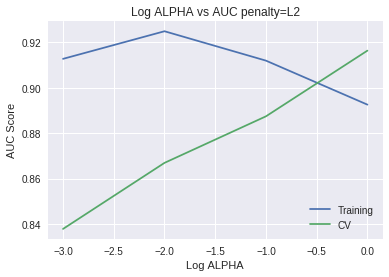

In [0]:
plt.plot(Alpha,AUC_score_training,label='Training')
plt.plot(Alpha,AUC_score_cv,label='CV')
plt.ylabel('AUC Score')
plt.xlabel('Log ALPHA')
plt.title('Log ALPHA vs AUC penalty=L2')
plt.legend()
plt.show()

**Simple Cross Validation Penalty='l1'**

In [0]:
AUC_score_training=[]
AUC_score_cv=[]
Alpha=[]
alpha=0.0001
while(alpha<=10000):
  clf=SGDClassifier(loss='hinge',penalty='l1',alpha=alpha)
  clf.fit(train_bows,y_train)
  
  #For Train Curve
  y_predict_training=clf.predict(train_bows)
  fpr,tpr,thresholds=roc_curve(y_predict_training,y_train)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    Alpha.append(math.ceil(math.log(alpha,10)))
    AUC_score_training.append(metrics.auc(fpr,tpr))
    print("Alpha= ",alpha," ",metrics.auc(fpr,tpr))
  
  # For CV Curve
  y_predict_cv=clf.predict(cv_bows)
  fpr,tpr,thresholds=roc_curve(y_predict_cv,y_cv)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    #Alpha.append(math.ceil(math.log(alpha,10)))
    AUC_score_cv.append(metrics.auc(fpr,tpr))
    print("Alpha= ",alpha," ",metrics.auc(fpr,tpr))
  
  alpha*=10

Alpha=  0.0001   0.8467244902555786
Alpha=  0.0001   0.8215854006273167
Alpha=  0.001   0.825490622104355
Alpha=  0.001   0.8317487987823721


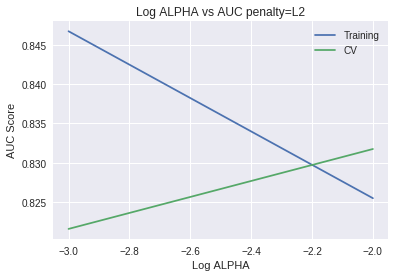

In [0]:
plt.plot(Alpha,AUC_score_training,label='Training')
plt.plot(Alpha,AUC_score_cv,label='CV')
plt.ylabel('AUC Score')
plt.xlabel('Log ALPHA')
plt.title('Log ALPHA vs AUC penalty=L2')
plt.legend()
plt.show()

**Obsrvation:** Optimal value of Alpha=1 with Penalty =L2 having AUC Score=0.92

In [0]:
#For Optimal on test data
count_vectorizer=CountVectorizer()
Train_bows=count_vectorizer.fit_transform(Train_data)
test_bows=count_vectorizer.transform(test_data)


 AUC =  0.8982164308595836


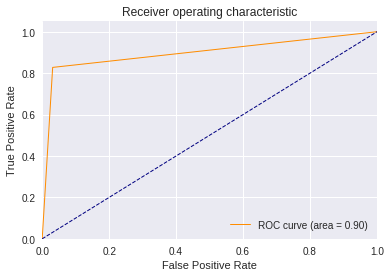




              precision    recall  f1-score   support

           0       0.97      0.01      0.01      5195
           1       0.83      1.00      0.91     24805

   micro avg       0.83      0.83      0.83     30000
   macro avg       0.90      0.50      0.46     30000
weighted avg       0.85      0.83      0.75     30000



In [0]:
clf = SGDClassifier(alpha=0.1, penalty='l2') 
clf.fit(Train_bows,y_Train)
y_pred=clf.predict(test_bows)
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_pred, y_test)
roc_auc = auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print("\n\n")
print(metrics.classification_report(y_test,y_pred))

**Top Positive Features**

In [0]:
feature_names=count_vector.get_feature_names()
w=clf.coef_
top=zip(w[0],feature_names)
top=list(top)
top.sort(reverse=True,key=lambda x:x[0])
l=len(top[0])
print('Weight\t\tTop Positive Feature')
for i in range (1,20):
  print("%.2f\t\t"%top[i][0],top[i][1])

Weight		Top Positive Feature
0.26		 optionalonion
0.24		 informal
0.24		 bookcase
0.20		 dye
0.16		 orally
0.14		 graaaaaaaandmama
0.14		 grogg
0.13		 gasm
0.13		 schillings
0.11		 pureeing
0.11		 final
0.10		 sobeys
0.10		 oevres
0.09		 juces
0.09		 optioned
0.08		 zuppa
0.08		 sublimer
0.08		 sulfites
0.08		 kronung


**Top Negative Features**

In [0]:
feature_names=count_vector.get_feature_names()
w=clf.coef_
top=zip(w[0],feature_names)
top=list(top)
top.sort(key=lambda x:x[0])
l=len(top[0])
print('Weight\t\tTop Negative Feature')
for i in range (1,20):
  print("%.2f\t\t"%top[i][0],top[i][1])

Weight		Top Negative Feature
-0.07		 racoons
-0.07		 escalating
-0.07		 poppie
-0.05		 teeths
-0.05		 bbcs
-0.05		 patties
-0.05		 leaks
-0.05		 tempts
-0.05		 bavarian
-0.04		 fuzzy
-0.04		 xoxo
-0.04		 relied
-0.04		 werw
-0.03		 eggs
-0.03		 waffles
-0.03		 cafes
-0.03		 necessacity
-0.03		 survey
-0.03		 rainfall


**5.1.2 TFIDF**

In [0]:
from sklearn.calibration import CalibratedClassifierCV

**Simple Cross Validation penalty=l2**

In [0]:
AUC_score_training=[]
AUC_score_cv=[]
Alpha_training=[]
Alpha_cv=[]
alpha=0.0001
while(alpha<=10000):
  clf=SGDClassifier(loss='hinge',penalty='l2',alpha=alpha)
  calibarator=CalibratedClassifierCV(clf,cv=3,method='sigmoid')
  calibarator.fit(train_tfidf,y_train)
  
  #For Train Curve
  y_predict_training=calibarator.predict(train_tfidf)
  fpr,tpr,thresholds=roc_curve(y_predict_training,y_train)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    Alpha_training.append(math.ceil(math.log(alpha,10)))
    AUC_score_training.append(metrics.auc(fpr,tpr))
    print("Alpha= ",alpha," ",metrics.auc(fpr,tpr))
  
  # For CV Curve
  clf.fit(train_tfidf,y_train)
  calibarator=CalibratedClassifierCV(clf,cv='prefit',method='sigmoid')
  calibarator.fit(train_tfidf,y_train)
  y_predict_cv=calibarator.predict(cv_tfidf)
  fpr,tpr,thresholds=roc_curve(y_predict_cv,y_cv)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    Alpha_cv.append(math.ceil(math.log(alpha,10)))
    AUC_score_cv.append(metrics.auc(fpr,tpr))
    print("Alpha= ",alpha," ",metrics.auc(fpr,tpr))
  
  alpha*=10
  

Alpha=  0.0001   0.9105533384296854
Alpha=  0.0001   0.8672409879910187
Alpha=  0.001   0.8926648324908542
Alpha=  0.001   0.8647018209487822
Alpha=  0.01   0.8922778982780752
Alpha=  0.01   0.8645082020555322


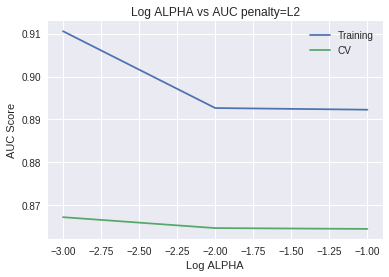

In [0]:
plt.plot(Alpha_training,AUC_score_training,label='Training')
plt.plot(Alpha_cv,AUC_score_cv,label='CV')
plt.ylabel('AUC Score')
plt.xlabel('Log ALPHA')
plt.title('Log ALPHA vs AUC penalty=L2')
plt.legend()
plt.show()

**Simple Cross Validation Penalty-L2**

In [0]:
AUC_score_training=[]
AUC_score_cv=[]
Alpha_training=[]
Alpha_cv=[]
alpha=0.0001
while(alpha<=10000):
  clf=SGDClassifier(loss='hinge',penalty='l1',alpha=alpha)
  calibarator=CalibratedClassifierCV(clf,cv=3,method='sigmoid')
  calibarator.fit(train_tfidf,y_train)
  
  #For Train Curve
  y_predict_training=calibarator.predict(train_tfidf)
  fpr,tpr,thresholds=roc_curve(y_predict_training,y_train)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    Alpha_training.append(math.ceil(math.log(alpha,10)))
    AUC_score_training.append(metrics.auc(fpr,tpr))
    print("Alpha= ",alpha," ",metrics.auc(fpr,tpr))
  
  # For CV Curve
  clf.fit(train_tfidf,y_train)
  calibarator=CalibratedClassifierCV(clf,cv='prefit',method='sigmoid')
  calibarator.fit(train_tfidf,y_train)
  y_predict_cv=calibarator.predict(cv_tfidf)
  fpr,tpr,thresholds=roc_curve(y_predict_cv,y_cv)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    Alpha_cv.append(math.ceil(math.log(alpha,10)))
    AUC_score_cv.append(metrics.auc(fpr,tpr))
    print("Alpha= ",alpha," ",metrics.auc(fpr,tpr))
  
  alpha*=10
  

Alpha=  0.0001   0.8667890550186259
Alpha=  0.0001   0.8548126425949726


**Observation :** Optimal Value of ALPHA=10^-2

In [0]:
#For Optimal on test data
tfidf_vector=TfidfVectorizer()
Train_tfidf=tfidf_vector.fit_transform(Train_data)
test_tfidf=tfidf_vector.transform(test_data)

 AUC =  0.9134304476815893


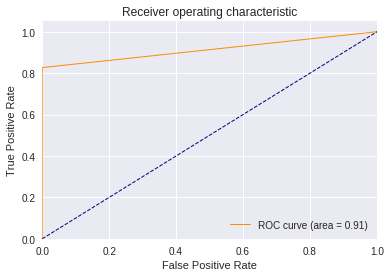




              precision    recall  f1-score   support

           0       1.00      0.00      0.00      5195
           1       0.83      1.00      0.91     24805

   micro avg       0.83      0.83      0.83     30000
   macro avg       0.91      0.50      0.45     30000
weighted avg       0.86      0.83      0.75     30000



In [0]:
clf = SGDClassifier(loss='hinge',alpha=0.001, penalty='l2') 
clf.fit(Train_tfidf,y_Train)
y_pred=clf.predict(test_tfidf)
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_pred, y_test)
roc_auc = auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print("\n\n")
print(metrics.classification_report(y_test,y_pred))

**Top Positive Features**

In [0]:
feature_names=count_vector.get_feature_names()
w=clf.coef_
top=zip(w[0],feature_names)
top=list(top)
top.sort(reverse=True,key=lambda x:x[0])
l=len(top[0])
print('Weight\t\tTop Positive Feature')
for i in range (1,20):
  print("%.2f\t\t"%top[i][0],top[i][1])

Weight		Top Positive Feature
0.47		 bookcase
0.39		 informal
0.39		 dye
0.38		 optionalonion
0.31		 schillings
0.29		 gasm
0.28		 pureeing
0.27		 orally
0.24		 grogg
0.23		 andmakes
0.23		 shine
0.22		 final
0.22		 graaaaaaaandmama
0.21		 kronung
0.21		 zuppa
0.21		 juces
0.21		 walkers
0.20		 optioned
0.19		 bazaar


**Top Negative Features**

In [0]:
feature_names=count_vector.get_feature_names()
w=clf.coef_
top=zip(w[0],feature_names)
top=list(top)
top.sort(key=lambda x:x[0])
l=len(top[0])
print('Weight\t\tTop Negative Feature')
for i in range (1,20):
  print("%.2f\t\t"%top[i][0],top[i][1])

Weight		Top Negative Feature
-0.69		 teeths
-0.67		 leaks
-0.55		 escalating
-0.53		 poppie
-0.50		 xoxo
-0.48		 racoons
-0.45		 escaped
-0.43		 eukanuba
-0.39		 survey
-0.36		 beech
-0.34		 bavarian
-0.33		 isculpted
-0.33		 eggs
-0.33		 escapesit
-0.32		 bos
-0.32		 prohibitive
-0.31		 concentated
-0.30		 bribed
-0.27		 simplifying


**5.1.3 Linear SVM on Avg Word2Vec**

In [0]:
AUC_score_training=[]
AUC_score_cv=[]
Alpha_training=[]
Alpha_cv=[]
alpha=0.0001
while(alpha<=10000):
  clf=SGDClassifier(loss='hinge',penalty='l2',alpha=alpha)
  calibarator=CalibratedClassifierCV(clf,cv=3,method='sigmoid')
  calibarator.fit(sent_vectors,y_train)
  
  #For Train Curve
  y_predict_training=calibarator.predict(sent_vectors)
  fpr,tpr,thresholds=roc_curve(y_predict_training,y_train)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    Alpha_training.append(math.ceil(math.log(alpha,10)))
    AUC_score_training.append(metrics.auc(fpr,tpr))
    print("Alpha= ",alpha," ",metrics.auc(fpr,tpr))
  
  # For CV Curve
  clf.fit(sent_vectors,y_train)
  calibarator=CalibratedClassifierCV(clf,cv='prefit',method='sigmoid')
  calibarator.fit(sent_vectors,y_train)
  y_predict_cv=calibarator.predict(sent_vectors_cv)
  fpr,tpr,thresholds=roc_curve(y_predict_cv,y_cv)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    Alpha_cv.append(math.ceil(math.log(alpha,10)))
    AUC_score_cv.append(metrics.auc(fpr,tpr))
    print("Alpha= ",alpha," ",metrics.auc(fpr,tpr))
  
  alpha*=10

Alpha=  0.0001   0.8149347446472874
Alpha=  0.0001   0.6530155648156404
Alpha=  0.001   0.8052316758747697
Alpha=  0.001   0.6572267096576034
Alpha=  0.01   0.8041421636915285
Alpha=  0.01   0.6586127714272283
Alpha=  0.1   0.8035116465645655
Alpha=  0.1   0.6567667363617083
Alpha=  1.0   0.8031964576952313
Alpha=  1.0   0.6456350480283706
Alpha=  10.0   0.5009912723087011
Alpha=  10.0   0.6006006247880036


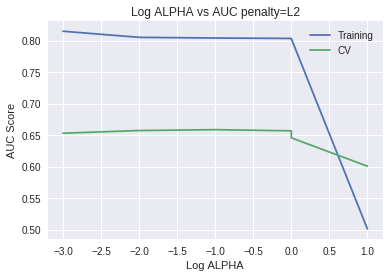

In [0]:
plt.plot(Alpha_training,AUC_score_training,label='Training')
plt.plot(Alpha_cv,AUC_score_cv,label='CV')
plt.ylabel('AUC Score')
plt.xlabel('Log ALPHA')
plt.title('Log ALPHA vs AUC penalty=L2')
plt.legend()
plt.show()

 **Observation:** Optimal value of ALPHA=1

 AUC =  0.68982385374194


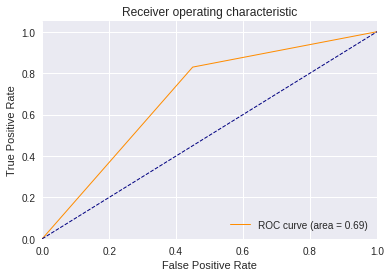




              precision    recall  f1-score   support

           0       0.55      0.02      0.04      5195
           1       0.83      1.00      0.91     24805

   micro avg       0.83      0.83      0.83     30000
   macro avg       0.69      0.51      0.47     30000
weighted avg       0.78      0.83      0.75     30000



In [0]:
clf = SGDClassifier(loss='hinge',alpha=0.01, penalty='l2') 
clf.fit(sent_vectors,y_train)
y_pred=clf.predict(sent_vectors_test)
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_pred, y_test)
roc_auc = auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print("\n\n")
print(metrics.classification_report(y_test,y_pred))

**5.1.4 Linear SVM on TF-IDF Weighted Word2Vec**

In [0]:
AUC_score_training=[]
AUC_score_cv=[]
Alpha_training=[]
Alpha_cv=[]
alpha=0.0001
while(alpha<=10000):
  clf=SGDClassifier(loss='hinge',penalty='l2',alpha=alpha)
  calibarator=CalibratedClassifierCV(clf,cv=3,method='sigmoid')
  calibarator.fit(tfidf_sent_vectors_train,y_train)
  
  #For Train Curve
  y_predict_training=calibarator.predict(tfidf_sent_vectors_train)
  fpr,tpr,thresholds=roc_curve(y_predict_training,y_train)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    Alpha_training.append(math.ceil(math.log(alpha,10)))
    AUC_score_training.append(metrics.auc(fpr,tpr))
    print("Alpha= ",alpha," ",metrics.auc(fpr,tpr))
  
  # For CV Curve
  clf.fit(tfidf_sent_vectors_train,y_train)
  calibarator=CalibratedClassifierCV(clf,cv='prefit',method='sigmoid')
  calibarator.fit(tfidf_sent_vectors_train,y_train)
  y_predict_cv=calibarator.predict(tfidf_sent_vectors_cv)
  fpr,tpr,thresholds=roc_curve(y_predict_cv,y_cv)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    Alpha_cv.append(math.ceil(math.log(alpha,10)))
    AUC_score_cv.append(metrics.auc(fpr,tpr))
    print("Alpha= ",alpha," ",metrics.auc(fpr,tpr))
  
  alpha*=10

Alpha=  0.0001   0.7951202128576083
Alpha=  0.0001   0.6265252389896125
Alpha=  0.001   0.7875056049462079
Alpha=  0.001   0.6686059174873505
Alpha=  0.01   0.7878853488664248
Alpha=  0.01   0.6779696240236912
Alpha=  0.1   0.7829895202366216
Alpha=  0.1   0.6833423759606929
Alpha=  1.0   0.80172763211522
Alpha=  1.0   0.6594592125343026
Alpha=  10.0   0.5338300795296481
Alpha=  10.0   0.5718814413113962


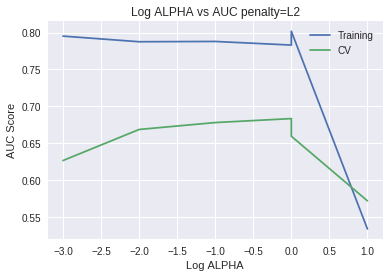

In [0]:
plt.plot(Alpha_training,AUC_score_training,label='Training')
plt.plot(Alpha_cv,AUC_score_cv,label='CV')
plt.ylabel('AUC Score')
plt.xlabel('Log ALPHA')
plt.title('Log ALPHA vs AUC penalty=L2')
plt.legend()
plt.show()

**OBSERVATION:-** Optimal value of ALPHA =1

 AUC =  0.6407675720769213


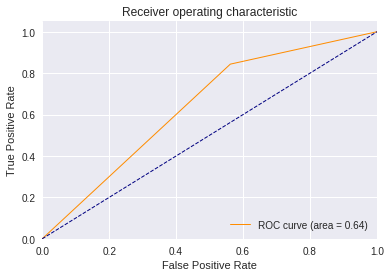




              precision    recall  f1-score   support

           0       0.44      0.15      0.22      5195
           1       0.84      0.96      0.90     24805

   micro avg       0.82      0.82      0.82     30000
   macro avg       0.64      0.55      0.56     30000
weighted avg       0.77      0.82      0.78     30000



In [0]:
clf = SGDClassifier(loss='hinge',alpha=0.001, penalty='l2') 
clf.fit(tfidf_sent_vectors_train,y_train)
y_pred=clf.predict(tfidf_sent_vectors_test)
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_pred, y_test)
roc_auc = auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print("\n\n")
print(metrics.classification_report(y_test,y_pred))

# 5.2 RBF SVM

In [0]:
from sklearn.svm import SVC

**5.2.1 RBF SVM on BOWs**

**Simple Cross Validation**

In [0]:
AUC_score_training=[]
AUC_score_cv=[]
C=[]
c=0.0001
while(c<=10000):
  clf=SVC(C=c,kernel='rbf',gamma='auto')
  clf.fit(train_bows_rbf,y_train_rbf)
  
  #For Train Curve
  y_predict_training=clf.predict(train_bows_rbf)
  fpr,tpr,thresholds=roc_curve(y_predict_training,y_train_rbf)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    C.append(math.ceil(math.log(c,10)))
    AUC_score_training.append(metrics.auc(fpr,tpr))
    print("Train->C= ",c," ",metrics.auc(fpr,tpr))
  
  # For CV Curve
  y_predict_cv=clf.predict(cv_bows_rbf)
  fpr,tpr,thresholds=roc_curve(y_predict_cv,y_cv_rbf)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    #Alpha.append(math.ceil(math.log(alpha,10)))
    AUC_score_cv.append(metrics.auc(fpr,tpr))
    print("CV->C= ",c," ",metrics.auc(fpr,tpr))
  
  c*=10

Train->C=  1.0   0.9318437468043768
CV->C=  1.0   0.9115054787994283
Train->C=  10.0   0.9096772222713321
CV->C=  10.0   0.8185929055729211
Train->C=  100.0   0.9477571340610438
CV->C=  100.0   0.7935450282242494
Train->C=  1000.0   0.9889360707012821
CV->C=  1000.0   0.7666090899574098
Train->C=  10000.0   0.9992149769478472
CV->C=  10000.0   0.746185565777856


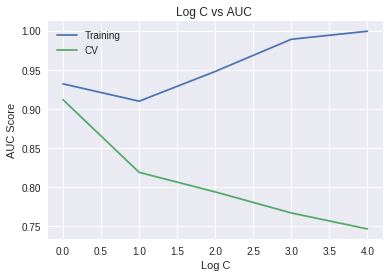

In [0]:
plt.plot(C,AUC_score_training,label='Training')
plt.plot(C,AUC_score_cv,label='CV')
plt.ylabel('AUC Score')
plt.xlabel('Log C')
plt.title('Log C vs AUC ')
plt.legend()
plt.show()

**Observation:** Optimal value of C=1

In [0]:
#For Optimal on test data
count_vectorizer_rbf=CountVectorizer()
Train_bows_rbf=count_vectorizer_rbf.fit_transform(Train_data_rbf)
test_bows_rbf=count_vectorizer_rbf.transform(test_data_rbf)


 AUC =  0.9133188864810802


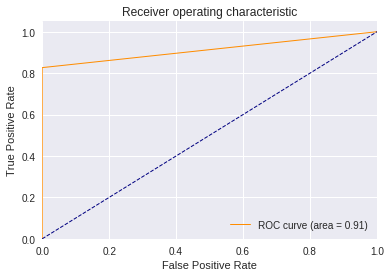




              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1041
           1       0.83      1.00      0.91      4959

   micro avg       0.83      0.83      0.83      6000
   macro avg       0.91      0.50      0.45      6000
weighted avg       0.86      0.83      0.75      6000



In [204]:
clf = SVC(C=10,kernel='rbf',gamma='auto')
clf.fit(Train_bows_rbf,y_Train_rbf)
y_pred=clf.predict(test_bows_rbf)
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_pred, y_test_rbf)
roc_auc = auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print("\n\n")
print(metrics.classification_report(y_test_rbf,y_pred))

**5.1.2 RBF SVM on TFIDF**

In [203]:
AUC_score_training=[]
AUC_score_cv=[]
C=[]
c=0.0001
while(c<=10000):
  clf=SVC(C=c,kernel='rbf',gamma='auto')
  clf.fit(train_tfidf_rbf,y_train_rbf)
  
  #For Train Curve
  y_predict_training=clf.predict(train_tfidf_rbf)
  fpr,tpr,thresholds=roc_curve(y_predict_training,y_train_rbf)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    C.append(math.ceil(math.log(c,10)))
    AUC_score_training.append(metrics.auc(fpr,tpr))
    print("Train->C= ",c," ",metrics.auc(fpr,tpr))
  
  # For CV Curve
  y_predict_cv=clf.predict(cv_tfidf_rbf)
  fpr,tpr,thresholds=roc_curve(y_predict_cv,y_cv_rbf)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    #Alpha.append(math.ceil(math.log(alpha,10)))
    AUC_score_cv.append(metrics.auc(fpr,tpr))
    print("CV->C= ",c," ",metrics.auc(fpr,tpr))
  
  c*=10
  

Train->C=  1000.0   0.9309623430962344
CV->C=  1000.0   0.9114074779709455
Train->C=  10000.0   0.9730043217476936
CV->C=  10000.0   0.8844883314360058


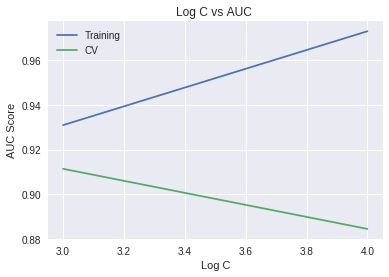

In [205]:
plt.plot(C,AUC_score_training,label='Training')
plt.plot(C,AUC_score_cv,label='CV')
plt.ylabel('AUC Score')
plt.xlabel('Log C')
plt.title('Log C vs AUC ')
plt.legend()
plt.show()

**Observation:** Optimal Value of C=10

In [206]:
clf

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
#For Optimal on test data
tfidf_vectorizer_rbf=TfidfVectorizer()
Train_tfidf_rbf=tfidf_vectorizer_rbf.fit_transform(Train_data_rbf)
test_tfidf_rbf=tfidf_vectorizer_rbf.transform(test_data_rbf)


 AUC =  0.7260514018691588


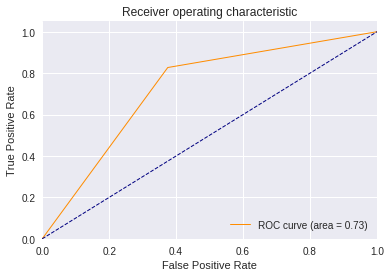




              precision    recall  f1-score   support

           0       0.62      0.00      0.01      1041
           1       0.83      1.00      0.91      4959

   micro avg       0.83      0.83      0.83      6000
   macro avg       0.73      0.50      0.46      6000
weighted avg       0.79      0.83      0.75      6000



In [210]:
clf = SVC(C=100,kernel='rbf',gamma='auto')
clf.fit(Train_tfidf_rbf,y_Train_rbf)
y_pred=clf.predict(test_bows_rbf)
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_pred, y_test_rbf)
roc_auc = auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print("\n\n")
print(metrics.classification_report(y_test_rbf,y_pred))

**5.2.3 RBF SVM on Avg Word2Vec**

In [211]:
AUC_score_training=[]
AUC_score_cv=[]
C=[]
c=0.0001
while(c<=10000):
  clf=SVC(C=c,kernel='rbf',gamma='auto')
  clf.fit(sent_vectors_rbf,y_train_rbf)
  
  #For Train Curve
  y_predict_training=clf.predict(sent_vectors_rbf)
  fpr,tpr,thresholds=roc_curve(y_predict_training,y_train_rbf)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    C.append(math.ceil(math.log(c,10)))
    AUC_score_training.append(metrics.auc(fpr,tpr))
    print("Train->C= ",c," ",metrics.auc(fpr,tpr))
  
  # For CV Curve
  y_predict_cv=clf.predict(sent_vectors_rbf_cv)
  fpr,tpr,thresholds=roc_curve(y_predict_cv,y_cv_rbf)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    #Alpha.append(math.ceil(math.log(alpha,10)))
    AUC_score_cv.append(metrics.auc(fpr,tpr))
    print("CV->C= ",c," ",metrics.auc(fpr,tpr))
  
  c*=10
  

Train->C=  100.0   0.6809552969993876
CV->C=  100.0   0.4787508877233003
Train->C=  1000.0   0.8688704547843249
CV->C=  1000.0   0.538782816229117
Train->C=  10000.0   0.8439315955801923
CV->C=  10000.0   0.538782816229117


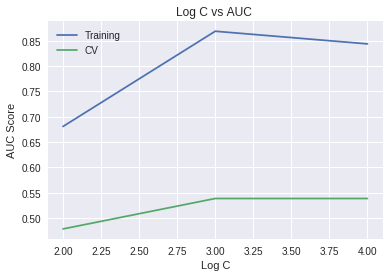

In [212]:
plt.plot(C,AUC_score_training,label='Training')
plt.plot(C,AUC_score_cv,label='CV')
plt.ylabel('AUC Score')
plt.xlabel('Log C')
plt.title('Log C vs AUC ')
plt.legend()
plt.show()

In [219]:
clf

SVC(C=10000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

 AUC =  0.5061918462460087


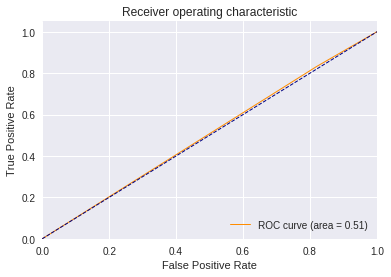




              precision    recall  f1-score   support

           0       0.18      0.43      0.25      1041
           1       0.83      0.59      0.69      4959

   micro avg       0.56      0.56      0.56      6000
   macro avg       0.51      0.51      0.47      6000
weighted avg       0.72      0.56      0.61      6000



In [228]:
clf = SVC(C=1000,kernel='rbf',gamma='auto')
clf.fit(sent_vectors_rbf,y_train_rbf)
y_pred=clf.predict(sent_vectors_rbf_test)
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_pred, y_test_rbf)
roc_auc = auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print("\n\n")
print(metrics.classification_report(y_test_rbf,y_pred))

**5.2.4  RBF SVM on TFIDF-W2Vec**

In [231]:
AUC_score_training=[]
AUC_score_cv=[]
C=[]
c=0.0001
while(c<=10000):
  clf=SVC(C=c,kernel='rbf',gamma='auto')
  clf.fit(tfidf_sent_vectors_rbf_train,y_train_rbf)
  
  #For Train Curve
  y_predict_training=clf.predict(tfidf_sent_vectors_rbf_train)
  fpr,tpr,thresholds=roc_curve(y_predict_training,y_train_rbf)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    C.append(math.ceil(math.log(c,10)))
    AUC_score_training.append(metrics.auc(fpr,tpr))
    print("Train->C= ",c," ",metrics.auc(fpr,tpr))
  
  # For CV Curve
  y_predict_cv=clf.predict(tfidf_sent_vectors_rbf_cv)
  fpr,tpr,thresholds=roc_curve(y_predict_cv,y_cv_rbf)
  if(not np.isnan(metrics.auc(fpr,tpr))):
    #Alpha.append(math.ceil(math.log(alpha,10)))
    AUC_score_cv.append(metrics.auc(fpr,tpr))
    print("CV->C= ",c," ",metrics.auc(fpr,tpr))
  
  c*=10
  

Train->C=  100.0   0.9310943242139649
CV->C=  100.0   0.5031833981484668
Train->C=  1000.0   0.8694263016616495
CV->C=  1000.0   0.538782816229117
Train->C=  10000.0   0.8703771584818554
CV->C=  10000.0   0.538782816229117


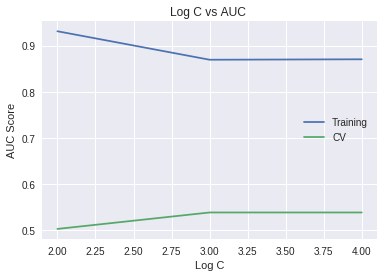

In [232]:
plt.plot(C,AUC_score_training,label='Training')
plt.plot(C,AUC_score_cv,label='CV')
plt.ylabel('AUC Score')
plt.xlabel('Log C')
plt.title('Log C vs AUC ')
plt.legend()
plt.show()

**Observation:** Optimal Value of C=1000

 AUC =  0.5119170493884453


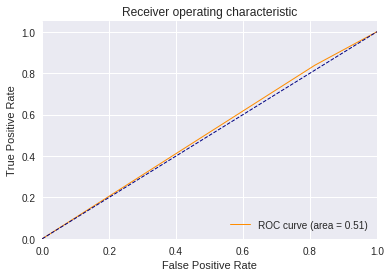




              precision    recall  f1-score   support

           0       0.19      0.53      0.27      1041
           1       0.84      0.51      0.64      4959

   micro avg       0.52      0.52      0.52      6000
   macro avg       0.51      0.52      0.46      6000
weighted avg       0.73      0.52      0.57      6000



In [237]:
clf = SVC(C=1000,kernel='rbf',gamma='auto')
clf.fit(tfidf_sent_vectors_rbf_train,y_train_rbf)
y_pred=clf.predict(tfidf_sent_vectors_rbf_test)
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_pred, y_test_rbf)
roc_auc = auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print("\n\n")
print(metrics.classification_report(y_test_rbf,y_pred))